# Project Statement:

## Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

## The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows

* Buoy
* Cruise_ship
* Ferry_boat
* Freight_boar
* Gondola
* Inflatable_boat
* Kayak
* Paper_boat
* Sailboat

## Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.

## As a deep learning engineer, your task is to:

1. Build a CNN network to classify the boat.
2. Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

# Dataset and Data Description: 

## The dataset folder is called Automating_Port_Operations_dataset 

## The dataset contains images of 9 types of boats. It contains a total of 1162 images. The training images are provided in the directory of the specific class itself. 
## Classes:
* ferry_boat
* gondola
* sailboat
* cruise_ship
* kayak
* inflatable_boat
* paper_boat
* buoy
* freight_boat




In [ ]:
#pip install tensorflow

# Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob

2024-09-21 03:20:09.428288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Defining the path for the dataset and displaying first image from each image directory

['buoy', 'gondola', 'ferry_boat', 'cruise_ship', 'freight_boat', 'kayak', 'sailboat', 'inflatable_boat', 'paper_boat']
/Users/master/GitProjects/BoatClassification_CNN_and_TransferLearning_Project/Automating_Port_Operations_dataset

Displaying first image from folder: buoy


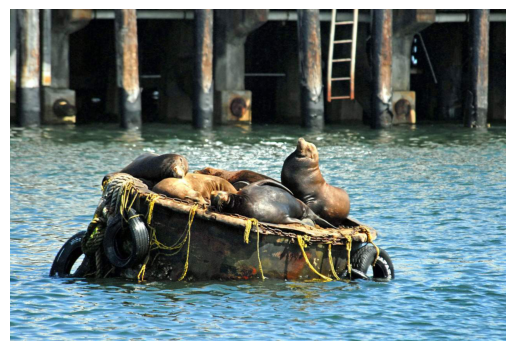

Displaying first image from folder: gondola


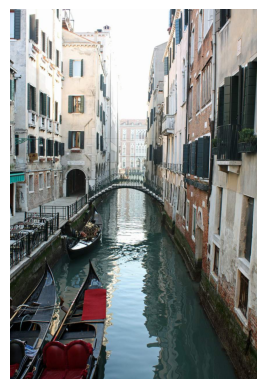

Displaying first image from folder: ferry_boat


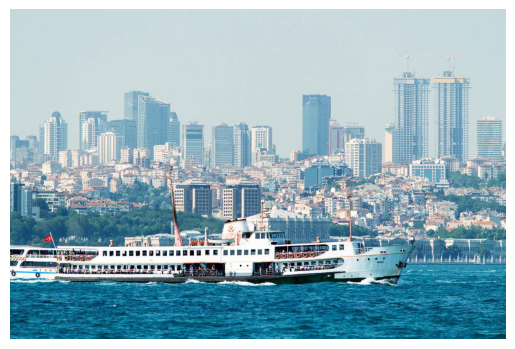

Displaying first image from folder: cruise_ship


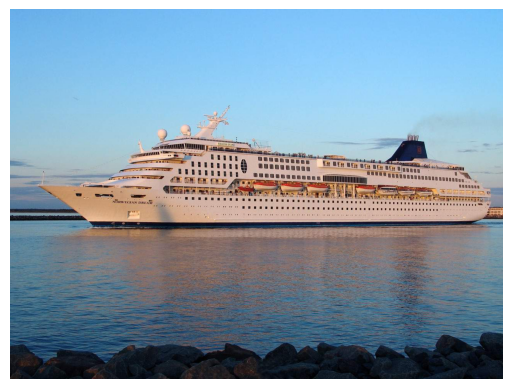

Displaying first image from folder: freight_boat


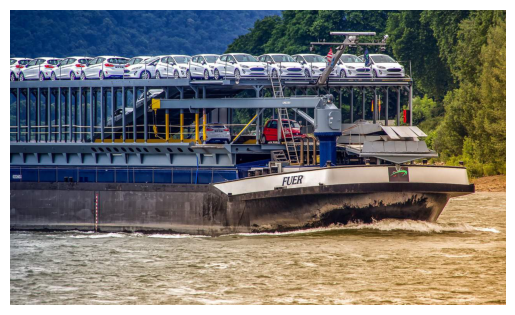

Displaying first image from folder: kayak


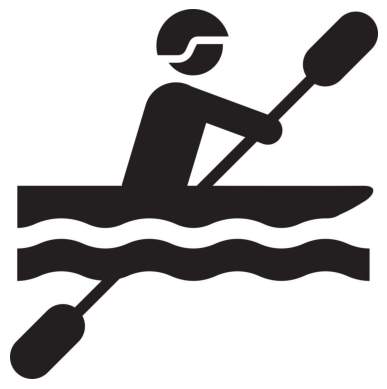

Displaying first image from folder: sailboat


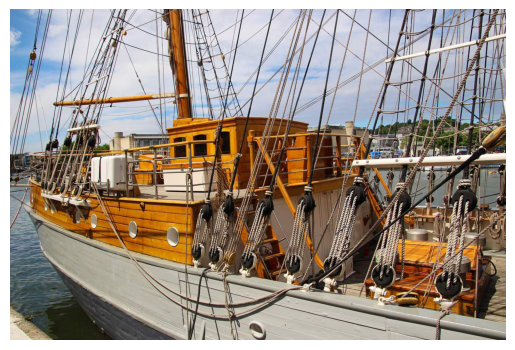

Displaying first image from folder: inflatable_boat


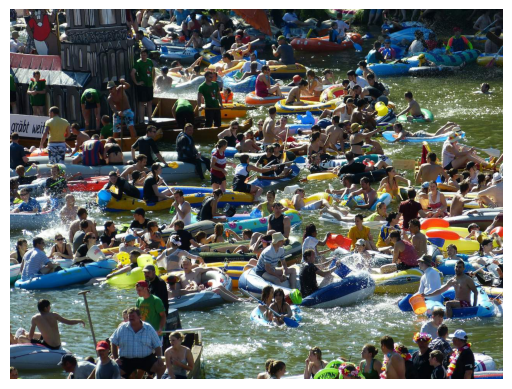

Displaying first image from folder: paper_boat


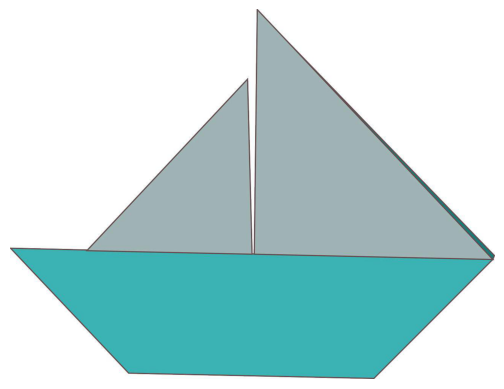

In [2]:

# Defining base path where dataset is located
data_dir = os.path.join(os.getcwd(), 'Automating_Port_Operations_dataset')

# Getting only visible directories (exclude hidden directories like .DS_Store)
image_dirs = [d for d in os.listdir(data_dir) if not d.startswith('.')]

print(image_dirs)
print(data_dir)
print()

# Function to display single image given an image path
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
# Displaying the first image in each directory in image_dirs
for d in image_dirs:
    image_path = os.path.join(data_dir, d, os.listdir(os.path.join(data_dir, d))[0])
    print(f"Displaying first image from folder: {d}")
    display_image(image_path)


# Creating training and datasets with following characteristics:

* Dataset will be split into train and test in the ratio 80:20, with shuffle and random state = 43
* We'll use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets with data normalization

* We'll load train, validation and test dataset in batches of 32 using the function initialized in step above

## Dataset Split into Training, Validation and Testing with normalzation

In [3]:
# Set parameters for training dataset
batch_size = 32
img_height = 150
img_width = 150
image_scale = 1./255  # Normalize pixel values to range [0, 1]

# Create training dataset: 80% train and 20% (validation + test) split
train_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80% for training, 20% for validation + test
  subset="training",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

# Create 20% validation + test set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 80% for training, 20% for validation + test
    subset="validation",
    seed=43,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Further split val_test_ds into 50% validation and 50% test (resulting in 10% each)
val_batches = int(0.5 * len(val_test_ds))

# First 50% of val_test_ds is validation set
val_ds = val_test_ds.take(val_batches)

# Last 50% of val_test_ds is test set
test_ds = val_test_ds.skip(val_batches)

# Normalize the pixel values for all datasets
def normalize_img(image, label):
    image = image * image_scale  # Scale pixel values between 0 and 1
    return image, label
  
# Apply normalization to train, validation, and test datasets
train_ds = train_val_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)

# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1162 files belonging to 9 classes.
Using 930 files for training.
Found 1162 files belonging to 9 classes.
Using 232 files for validation.


## Getting Class names

In [4]:
class_names = train_val_ds.class_names
print(f"Class names: {class_names}")

Class names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


## Visualizing images from training dataset

In [5]:

# Load train dataset with cache properly applied for better performance
# We shuffle the dataset and repeat it just b
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=43,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Cache after shuffling and before repeating the dataset
train_ds = train_ds.shuffle(buffer_size=1000).cache().repeat()

# Prefetch to optimize performance
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)





Found 1162 files belonging to 9 classes.
Using 930 files for training.


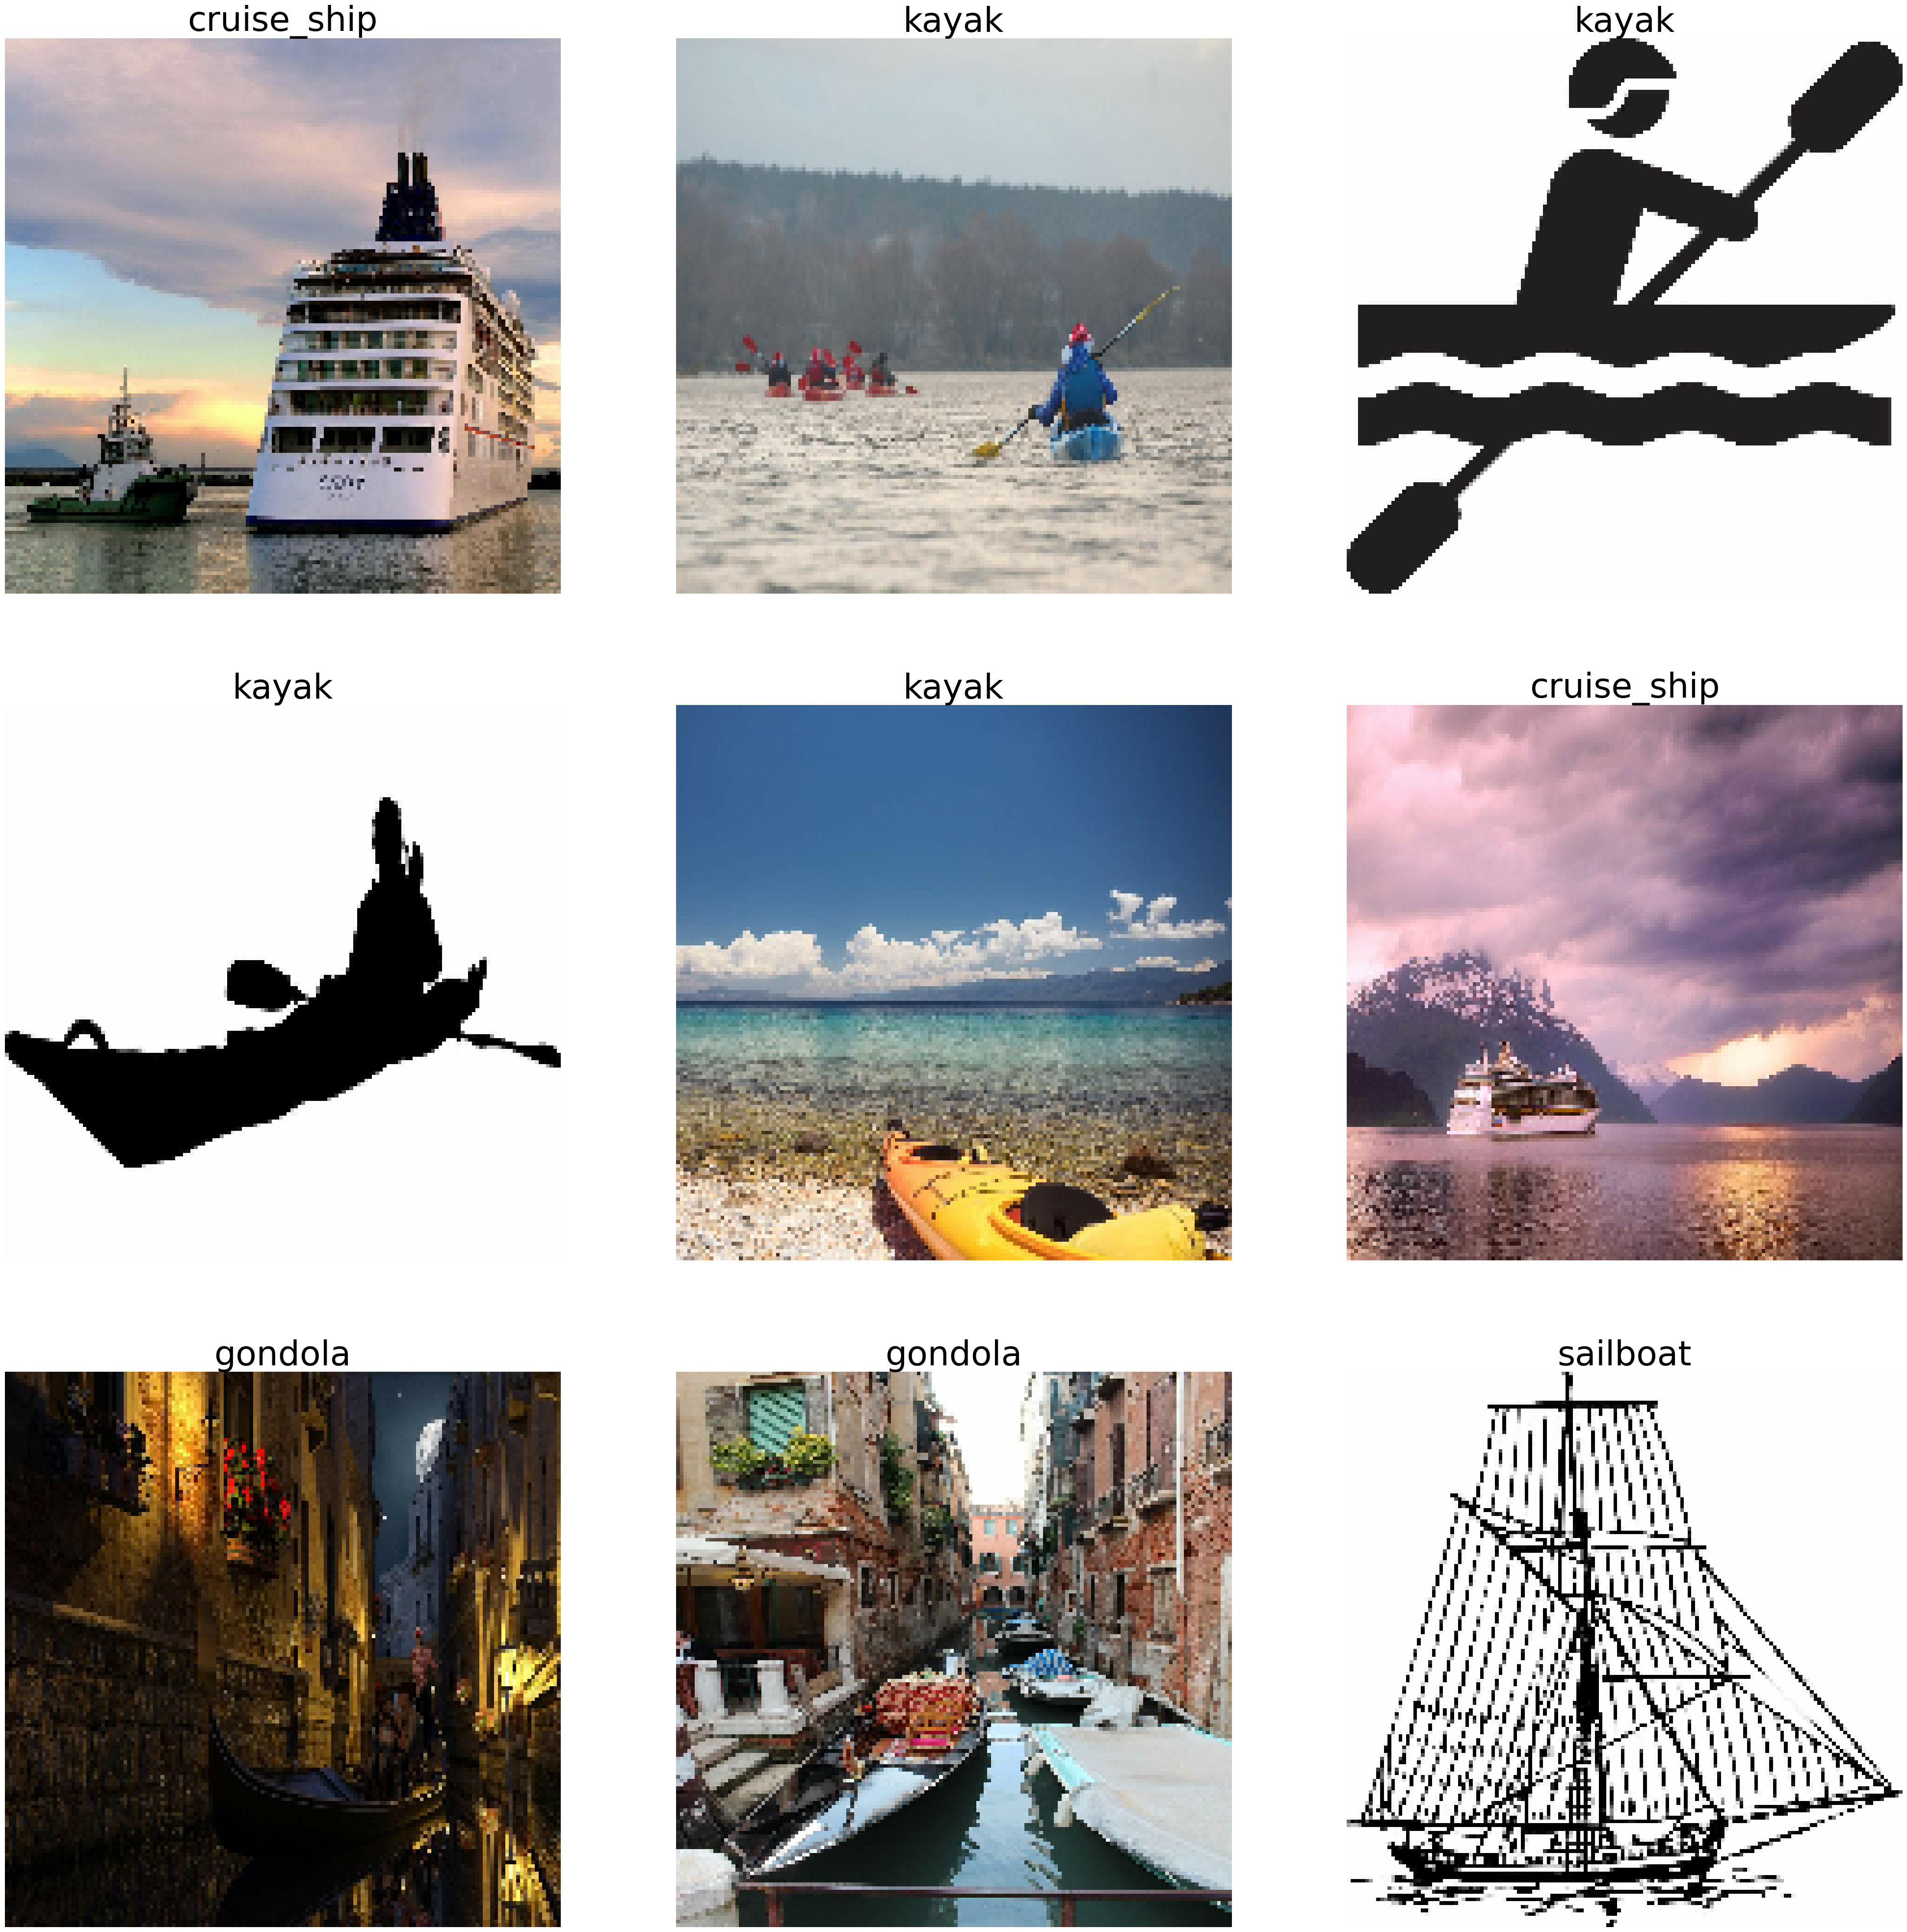

In [6]:
# Create an iterator over the dataset without using .take() method 
# which is used to get a specific number of batches, but is causing warnings

iterator = iter(train_ds)

# Get one batch from the dataset
images, labels = next(iterator)

# Plot the first 9 images from the batch
plt.figure(figsize=(50, 50))
for i in range(9):  # Displaying only 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], fontsize=50)
    plt.axis("off")
plt.show()
